In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(r'C:\Users\Mohamed Fawzi\Desktop\RFM Analysis\rfm_data.csv')
df.head()

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,2023-04-11,943.31,Product C,890075,Tokyo
1,2188,2023-04-11,463.70,Product A,176819,London
2,4608,2023-04-11,80.28,Product A,340062,New York
3,2559,2023-04-11,221.29,Product A,239145,London
4,9482,2023-04-11,739.56,Product A,194545,Paris


### Preparing Data

In [45]:
#convert CustomerID to string
df['CustomerID'] = df['CustomerID'].astype(str)

#convert PurchaseDate to datetime
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

#check for null values
df.isnull().sum()

#check for duplicates
df.drop_duplicates(inplace=True)

df.head()

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,2023-04-11,943.31,Product C,890075,Tokyo
1,2188,2023-04-11,463.70,Product A,176819,London
2,4608,2023-04-11,80.28,Product A,340062,New York
3,2559,2023-04-11,221.29,Product A,239145,London
4,9482,2023-04-11,739.56,Product A,194545,Paris


In [46]:
# I will define the analysis date as the max date in the dataset
analysis_date = df['PurchaseDate'].max()

##  **Calculating The RFM Values:**


-   What is Recency (R)?

    -   Definition: How recently a customer made a purchase.

    -   Purpose: Customers who bought something more recently are more likely to respond to promotions or return to buy again.

    -   Example: If Customer A bought something yesterday and Customer B bought something 3 months ago, Customer A has a better Recency score.

-   What's Frequency (F)?
    -    Definition: How often a customer makes purchases in a given period.

    -   Purpose: Frequent buyers are usually more loyal and more engaged with your brand.

    -    Example: If Customer A made 10 purchases this year and Customer B made 2, Customer A has a higher Frequency score.

-   What's Monetary (M)?
    -   Definition: How much money a customer has spent.

    -   Purpose: High-spending customers are more valuable to your business.

    -   Example: If Customer A has spent $1,000 in total and Customer B has spent $200, Customer A scores higher on Monetary.

In [47]:
# create a df to calculate the recency
recency_df = df.groupby('CustomerID')['PurchaseDate'].max().reset_index()
recency_df['Recency'] =  (analysis_date - recency_df['PurchaseDate']).dt.days
recency_df.drop('PurchaseDate', axis=1, inplace=True)
recency_df.head()

,CustomerID,Recency
0,1011,33
1,1025,21
2,1029,0
3,1046,43
4,1049,13


In [48]:
# Frequency: Number of transactions per customer
frequency_df = df.groupby('CustomerID')['OrderID'].count().reset_index().rename(columns={'OrderID': 'Frequency'})
frequency_df.head()

,CustomerID,Frequency
0,1011,2
1,1025,1
2,1029,1
3,1046,1
4,1049,1


In [49]:
# Monetary: Total transaction amount per customer
monetary_df = df.groupby('CustomerID')['TransactionAmount'].sum().reset_index().rename(columns={'TransactionAmount': 'Monetary'})

monetary_df.head()

,CustomerID,Monetary
0,1011,1129.02
1,1025,359.29
2,1029,704.99
3,1046,859.82
4,1049,225.72


In [50]:
# Merge RFM metrics
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,1011,33,2,1129.02
1,1025,21,1,359.29
2,1029,0,1,704.99
3,1046,43,1,859.82
4,1049,13,1,225.72


-   Now let's categorizes customers based on Recency, Frequency, and Monetary values using scoring systems. Recency is ranked inversely (lower is better), while Frequency and Monetary values are ranked positively (higher is better). It assigns scores from 1 to 5, converts them into integers, and prepares the data for further RFM analysis


In [51]:
# Recency: Lower is better
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], q=5, labels=[5, 4, 3, 2, 1])

# Frequency: Higher is better
rfm_df['F_Score'] = pd.cut(rfm_df['Frequency'], bins=5, labels=[1, 2, 3, 4, 5])

# Monetary: Higher is better
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], q=5, labels=[1, 2, 3, 4, 5])

# Convert scores to integers
rfm_df['R_Score'] = rfm_df['R_Score'].astype(int)
rfm_df['F_Score'] = rfm_df['F_Score'].astype(int)
rfm_df['M_Score'] = rfm_df['M_Score'].astype(int)

rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,1011,33,2,1129.02,3,3,5
1,1025,21,1,359.29,4,1,2
2,1029,0,1,704.99,5,1,4
3,1046,43,1,859.82,2,1,5
4,1049,13,1,225.72,4,1,2


In [52]:
# Overall RFM Score
rfm_df['RFM_Overall'] = rfm_df['R_Score'] + rfm_df['F_Score'] + rfm_df['M_Score']
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Overall
0,1011,33,2,1129.02,3,3,5,11
1,1025,21,1,359.29,4,1,2,7
2,1029,0,1,704.99,5,1,4,10
3,1046,43,1,859.82,2,1,5,8
4,1049,13,1,225.72,4,1,2,7


-   I will classify customers into different segments based on their Recency, Frequency, and Monetary scores. Customers with high values across all metrics are labeled as Champions, while those showing loyalty or frequent spending are categorized accordingly. Recent customers and those at risk of disengagement are also identified, helping businesses tailor their marketing strategies


In [63]:
# create a column for customer segment based on RFM Overall score
def rfm_segment(row):
    if row['RFM_Overall'] >= 12:
        return 'Champions'
    elif row['RFM_Overall'] >= 9:
        return 'Loyal Customers'
    elif row['RFM_Overall'] >= 6:
        return 'Potential Loyalists'
    elif row['RFM_Overall'] >= 3:
        return 'Frequent Spenders'
    else:
        return 'At Risk'
rfm_df['Customer_Segment'] = rfm_df.apply(rfm_segment, axis=1)
rfm_df.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Overall,Cusomer_Segment,Customer_Segment
0,1011,33,2,1129.02,3,3,5,11,Loyal Customers,Loyal Customers
1,1025,21,1,359.29,4,1,2,7,Potential Loyalists,Potential Loyalists
2,1029,0,1,704.99,5,1,4,10,Loyal Customers,Loyal Customers
3,1046,43,1,859.82,2,1,5,8,Potential Loyalists,Potential Loyalists
4,1049,13,1,225.72,4,1,2,7,Potential Loyalists,Potential Loyalists


----

##  **RFM Values Distribution:**


-   Now let's create histograms to visualize the distribution of Recency, Frequency, and Monetary values. Each subplot shows how these metrics are spread across customers, helping identify trends and skewness. The KDE (Kernel Density Estimation) curve provides insight into the overall shape of the data. 


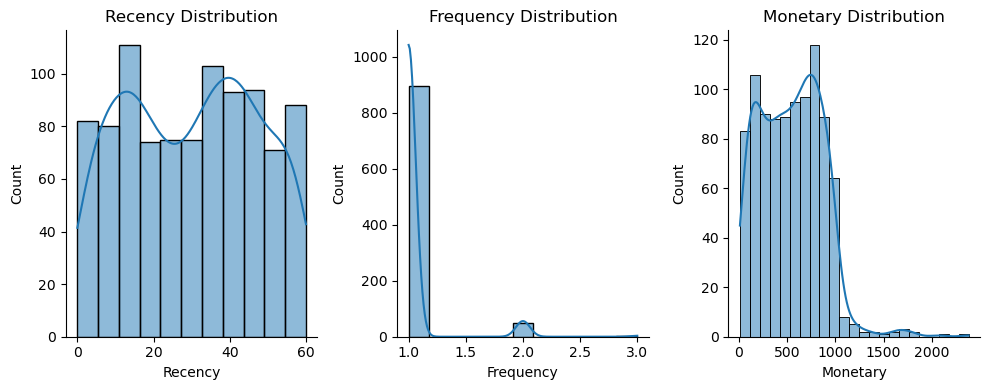

In [55]:
# Distribution of Recency, Frequency, Monetary
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], kde=True)
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], kde=True)
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary'], kde=True)
plt.title('Monetary Distribution')

sns.despine()
plt.tight_layout()
plt.show()



-   **Key Insights:**

    * **Recency:** The 'Recency' distribution seems somewhat uniform or even bimodal. Customers have made purchases across a wide range of recent times, with slight peaks around the shorter and longer recency values shown on the x-axis. This suggests a fairly active customer base with different segments in terms of their last purchase date.

    * **Frequency:** The 'Frequency' distribution is highly skewed to the right. The vast majority of customers have a purchase frequency of 1. There are very few customers with a frequency greater than 1, and even fewer with frequencies of 2 or 3. This indicates that most customers in this dataset are likely one-time purchasers.

    * **Monetary:** The 'Monetary' distribution is also skewed to the right, with a large concentration of customers having lower monetary values. There's a significant peak around the lower spending range, followed by a long tail indicating that a smaller number of customers contribute significantly higher amounts to the total revenue.

    In summary, you have a customer base where most people are recent, one-time buyers who spend a relatively small amount. However, there are also segments of customers who made purchases longer ago, and a smaller group of repeat customers and high-spending customers. This suggests opportunities for strategies focused on converting one-time buyers into repeat customers and nurturing the high-value customers.
____

-   Let's generates box plots to visualize outliers in the Recency, Frequency, and Monetary metrics. Box plots help identify extreme values, showing the distribution of each variable while highlighting potential anomalies that could impact RFM analysis.


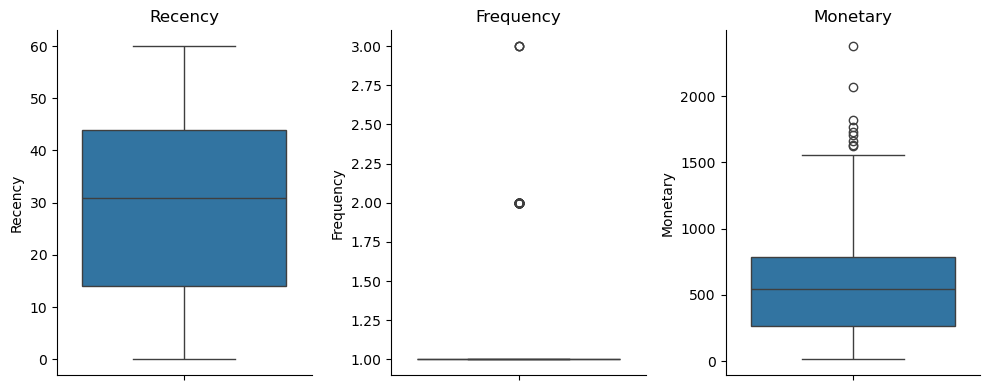

In [56]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
sns.boxplot(y=rfm_df['Recency'])
plt.title('Recency')

plt.subplot(1, 3, 2)
sns.boxplot(y=rfm_df['Frequency'])
plt.title('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(y=rfm_df['Monetary'])
plt.title('Monetary')


sns.despine()
plt.tight_layout()
plt.show()


* **Recency:** Most recent purchases fall between roughly 15 and 45, with a median around 30. No major outliers.
* **Frequency:** Almost all customers are one-time buyers (frequency of 1), with a few outliers of 2 or 3 purchases.
* **Monetary:** Typical spending is between 250 and 750 (median around 500), but there are several high-spending outliers.

**Key takeaway:** Mostly recent, one-time buyers with varied spending, including some significant high-value customers.

----

##  **RFM Score Analysis:**


-   Now let's visualize the distribution of Recency, Frequency, and Monetary scores using count plots. Each plot shows how many customers fall into each score category, helping analyze trends in customer behavior.

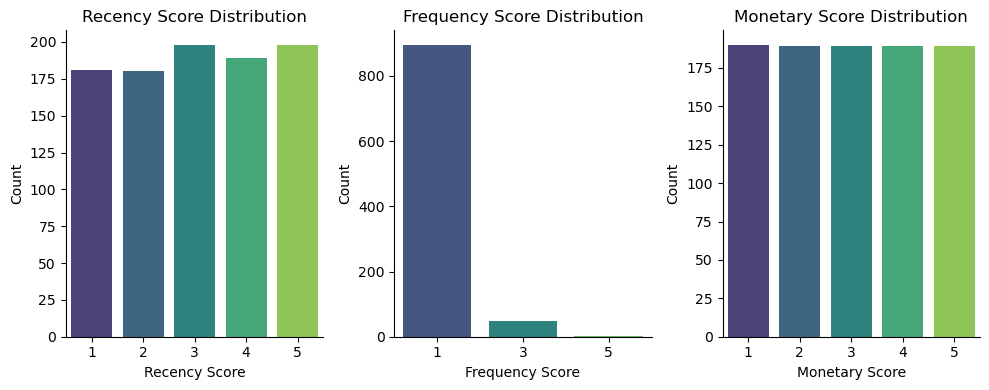

In [57]:
# Score distributions
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
sns.countplot(x='R_Score', data=rfm_df, ax=axes[0], palette='viridis')
sns.countplot(x='F_Score', data=rfm_df, ax=axes[1], palette='viridis')
sns.countplot(x='M_Score', data=rfm_df, ax=axes[2], palette='viridis')

axes[0].set_title('Recency Score Distribution')
axes[1].set_title('Frequency Score Distribution')
axes[2].set_title('Monetary Score Distribution')

#plt.suptitle('RFM Score Distributions')
axes[0].set_xlabel('Recency Score')
axes[1].set_xlabel('Frequency Score')
axes[2].set_xlabel('Monetary Score')

axes[0].set_ylabel('Count')
axes[1].set_ylabel('Count')
axes[2].set_ylabel('Count')


sns.despine()
plt.tight_layout()
plt.show()

* **Recency Score:** The distribution across recency scores (1 to 5) is fairly even. This suggests a good mix of customers with different levels of recent activity.

* **Frequency Score:** The vast majority of customers have a frequency score of 1. Scores of 3 and 5 have a very small representation. This strongly indicates that most customers are infrequent purchasers.

* **Monetary Score:** The distribution across monetary scores (1 to 5) is also quite even. This implies a good mix of customers across different spending tiers.

**In short:** You have a balanced distribution of customers based on how recently they purchased and how much they spend. However, most customers are infrequent buyers. This highlights an opportunity to focus on strategies that encourage repeat purchases.

_____

-   Now we'll create a correlation heatmap to analyze relationships between Recency, Frequency, and Monetary values. The heatmap visually represents the strength and direction of correlations, helping to identify patterns in customer behavior.


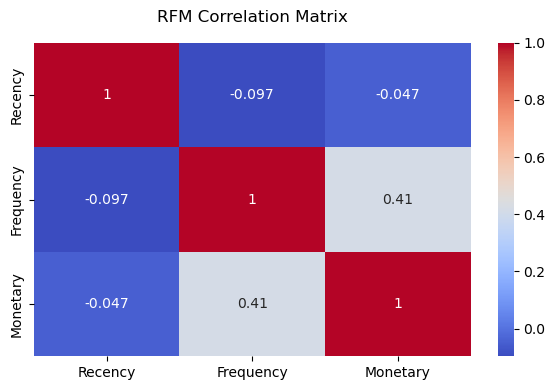

In [58]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(rfm_df[['Recency', 'Frequency', 'Monetary']].corr(), 
            annot=True, 
            cmap='coolwarm'
            
            )
plt.title('RFM Correlation Matrix', pad=15)

plt.tight_layout()
plt.show()

* **Recency and Frequency:** There's a very weak negative correlation (-0.097) between Recency and Frequency. This suggests that how recently a customer purchased has a negligible tendency to relate to how often they purchase.

* **Recency and Monetary:** Similarly, there's a very weak negative correlation (-0.047) between Recency and Monetary value. This indicates that how recently a customer purchased has almost no linear relationship with how much they've spent in total.

* **Frequency and Monetary:** There's a moderate positive correlation (0.41) between Frequency and Monetary value. This is interesting! It implies that customers who purchase more frequently tend to spend more overall. This makes intuitive sense, as repeat purchases accumulate over time.

**In brief:**

* Recency is pretty independent of both Frequency and Monetary value.
* Frequency and Monetary value have a noticeable positive relationship – more frequent buyers tend to be higher spenders.

-----

##  **Segment Analysis:**

-   Let's visualize the distribution of customer segments using a count plot. It sorts the segments by their frequency, making it easier to see which groups have the most customers. The rotated labels improve readability, and the plot helps businesses analyze customer engagement patterns effectively.


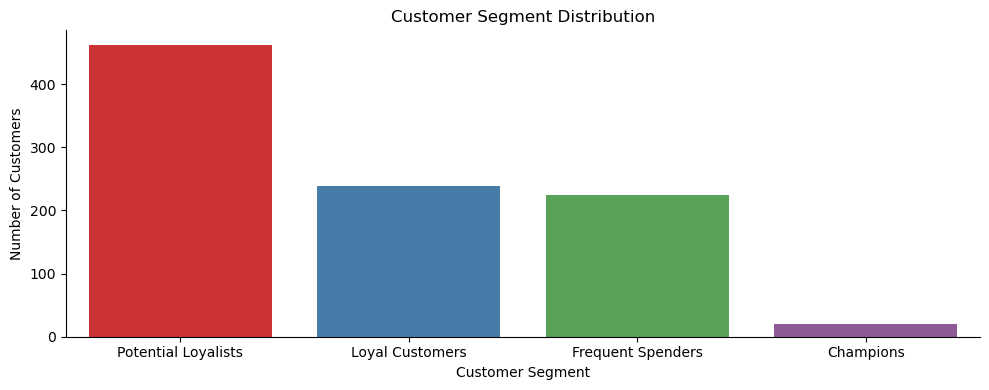

In [64]:
# Segment distribution
plt.figure(figsize=(10, 4))
sns.countplot(x='Customer_Segment', data=rfm_df, 
              order=rfm_df['Customer_Segment'].value_counts().index
              , palette='Set1')


plt.title('Customer Segment Distribution')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.title('Customer Segment Distribution')
plt.xticks(rotation=0)


sns.despine()
plt.tight_layout()
plt.show()

-   **Key Insights**
    * **Potential Loyalists:** This is by far the largest segment, with over 500 customers. This group likely represents recent customers with good spending habits but haven't purchased frequently yet. There's a significant opportunity to nurture these customers into loyal ones.

    * **Loyal Customers:** This is a much smaller segment, with just over 25 customers. These customers purchase frequently and recently, but their spending might not be as high as other groups. They are valuable and should be retained.

    * **Frequent Spenders:** This is an even smaller segment, with only around 10 customers. These customers purchase frequently and spend a good amount. They are highly valuable.

    * **Champions:** This is the smallest segment, with only a handful of customers. These are your best customers – they purchase frequently, recently, and spend the most. They are crucial to your business.
    ----------

-   Now I'll analyze the average monetary value for each customer segment. It helps businesses understand which segments contribute the most revenue, allowing for better targeting and strategy optimization. The rotated labels improve readability for longer segment names. 


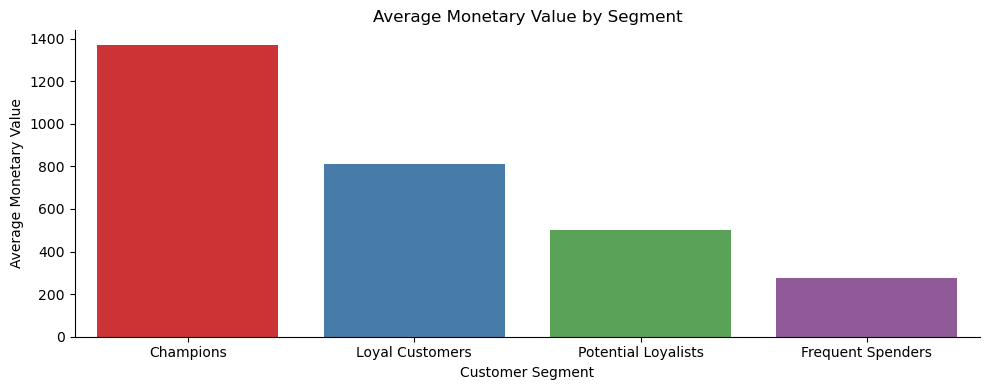

In [66]:
# Average Monetary Value by Segment
plt.figure(figsize=(10, 4))
sns.barplot(data=rfm_df,
            x='Customer_Segment', 
            y='Monetary', 
            palette='Set1',
            order=rfm_df.groupby('Customer_Segment')['Monetary'].mean().sort_values(ascending=False).index,
            ci=None
            )


plt.title('Average Monetary Value by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average Monetary Value')
plt.xticks(rotation=0)



sns.despine()
plt.tight_layout()
plt.show()

-   ## Key Insights:
    1. Champions – Highest Spend
        -   Avg. Monetary Value ≈ 1380

        -   This segment spends the most on average, reinforcing their status as your top-value customers.

    2. Loyal Customers – Strong Revenue Contributors

        -   Avg. Monetary Value ≈ 820

        -   These customers are reliable spenders but don't reach champion levels.

    3. Potential Loyalists – Mid-Range Spenders

        -   Avg. Monetary Value ≈ 510

        -   These customers are in a growth zone—they've started spending but haven’t reached high-value status yet.

    4. Frequent Spenders – Lowest Monetary Value

        -   Avg. Monetary Value ≈ 280

        -   These customers don’t spend much per transaction, despite their label suggesting frequency.

        ------------

In [120]:
# Average Recency, Frequency, and Monetary by Segment
segment_analysis = rfm_df.groupby('Customer_Segment')[['R_Score', 'F_Score', 'M_Score']].mean().reset_index()

segment_analysis['RFM_Overall'] = segment_analysis[['R_Score', 'F_Score', 'M_Score']].mean(axis=1)

segment_analysis = segment_analysis.sort_values(by='RFM_Overall', ascending=False)
segment_analysis

,Customer_Segment,R_Score,F_Score,M_Score,RFM_Overall
0,Champions,4.500000,3.300000,4.950000,4.250000
2,Loyal Customers,4.133891,1.225941,4.334728,3.231520
3,Potential Loyalists,3.114719,1.017316,2.846320,2.326118
1,Frequent Spenders,1.617778,1.000000,1.715556,1.444444


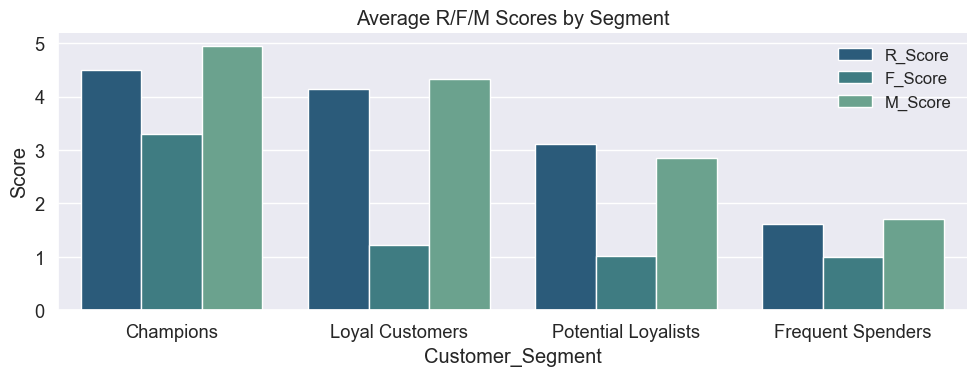

In [119]:
# Melt data for plotting
melted = segment_analysis.melt(id_vars='Customer_Segment', value_vars=['R_Score', 'F_Score', 'M_Score'], 
                               var_name='RFM Score', value_name='Score')

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(data=melted,
            x='Customer_Segment', 
            y='Score', 
            hue='RFM Score',  
            ci=None,
            palette='crest_r'
            )
plt.xticks(rotation=0)
plt.title('Average R/F/M Scores by Segment',)
plt.ylabel('Score')


plt.legend(ncol=1, loc='upper right', fontsize='small', frameon=False)


sns.despine()
plt.tight_layout()
plt.show()

-   ## Segment-by-Segment Insights:
    -   🏆 Champions
        -   High R (4.5) and Very High M (≈ 5.0) → they purchased recently and spend a lot.
        -   Moderate F (≈ 3.3) → not the most frequent, but still active.
        -   These are high-value recent spenders.
    -   Loyal Customers
        -   High R (≈ 4.1), Low F (≈ 1.2), and High M (≈ 4.3).
        -   They're spending a lot and buying recently, but not frequently.
        -   Possibly big purchases once in a while.

    -   Potential Loyalists
        -   Moderate R (≈ 3.1), Very Low F (≈ 1.0), Moderate M (≈ 2.8).
        -   They're early in the relationship—showing potential, but need nurturing.

    -   Frequent Spenders
        -   Low R (≈ 1.6), Very Low F (≈ 1.0), and Low M (≈ 1.7).
        -   This label might be misleading—they are not recent, not frequent, and not spending much.
    Possibly outdated or misclassified.

-   Overall Insights:
    -   Champions and Loyal Customers are your core drivers of value.
    -   Potential Loyalists are worth investing in—they're close to becoming core.
    -   "Frequent Spenders" might be a misnomer—review if their behavior matches the label.

----

##  **Product by Segment**

-   Now let's analyze each product by customer segment by merging customer segments with the original transaction data, allowing for deeper analysis of purchasing behavior. This helps businesses identify which products are most valuable to specific customer groups.


In [109]:
# let's merge segment data with original transactions
segment_products = df.merge(rfm_df[['CustomerID', 'Customer_Segment']], on='CustomerID')

# now aggregate product sales by segment
segment_products = segment_products.groupby(['Customer_Segment', 'ProductInformation'])['TransactionAmount'].sum().reset_index()
segment_products = segment_products.sort_values(['Customer_Segment', 'TransactionAmount'], ascending=[True, False]).round(2)

segment_products.head()


,Customer_Segment,ProductInformation,TransactionAmount
2,Champions,Product C,9145.66
3,Champions,Product D,6667.30
1,Champions,Product B,6301.43
0,Champions,Product A,5293.90
6,Frequent Spenders,Product C,18290.74


In [110]:
segment_count = segment_products.pivot_table(index='Customer_Segment', columns='ProductInformation', values='TransactionAmount', aggfunc='sum')
segment_count = segment_count.fillna(0).reset_index()

segment_count

ProductInformation,Customer_Segment,Product A,Product B,Product C,Product D
0,Champions,5293.90,6301.43,9145.66,6667.30
1,Frequent Spenders,12946.49,14115.11,18290.74,16316.33
2,Loyal Customers,45289.68,49063.17,54847.33,44840.59
3,Potential Loyalists,53889.86,53558.37,62207.76,60904.09


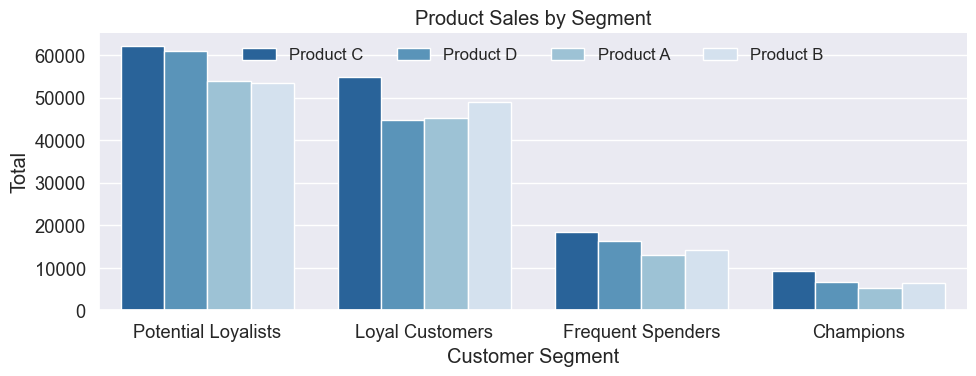

In [111]:
plt.figure(figsize=(10, 4))
sns.barplot(data=segment_count.melt(id_vars='Customer_Segment').sort_values('value', ascending=False),
            x='Customer_Segment', 
            y='value', 
            hue='ProductInformation', 
            palette='Blues_r'
            )


plt.title('Product Sales by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Total')
plt.xticks(rotation=0)
plt.legend(loc='upper center', fontsize='small', ncol=4, framealpha=0)

sns.despine()
plt.tight_layout()
plt.show()

-   ## Key Insights:

1. Potential Loyalists Are the Top-Contributing Segment

    -   Highest total sales across all products come from Potential Loyalists.
    -   Product C and D dominate in this group, followed closely by Product A and B.

2. Loyal Customers Drive Significant Revenue

    -   The second-highest contributing segment, also purchasing across all products.
    -   Product C again leads, but all products have solid performance.

3. Frequent Spenders Show Moderate Sales

    -   This segment contributes less than the two above, but consistently across products.
    -   They may purchase more frequently but spend less per transaction or focus on fewer products.

4. Champions Have Low Total Sales

    -   Surprisingly, Champions show the lowest sales volume across all products, despite typically being considered top customers.

------

Now I will create a new column in your DataFrame called Value Segment, which categorizes each customer based on their RFM score into:

-   Low-Value

-   Mid-Value

-   High-Value

In [112]:
# Create RFM segments based on the RFM score
segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']
rfm_df['Value Segment'] = pd.qcut(rfm_df['RFM_Overall'], q=3, labels=segment_labels)

rfm_df.head(2)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Overall,Cusomer_Segment,Customer_Segment,Value Segment
0,1011,33,2,1129.02,3,3,5,11,Loyal Customers,Loyal Customers,High-Value
1,1025,21,1,359.29,4,1,2,7,Potential Loyalists,Potential Loyalists,Mid-Value


In [113]:
customer_value_count = rfm_df['Value Segment'].value_counts().reset_index()
customer_value_count.columns = ['Value Segment', 'Customer Count']
customer_value_count

,Value Segment,Customer Count
0,Low-Value,369
1,Mid-Value,318
2,High-Value,259


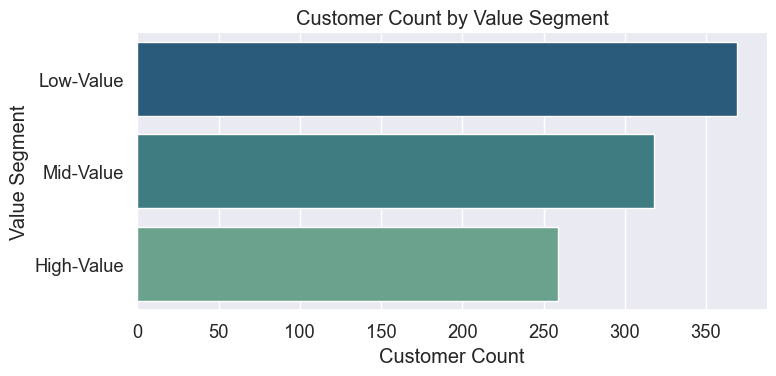

In [114]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=customer_value_count,
    x='Customer Count',
    y='Value Segment',
    palette='crest_r'
    
    )

plt.title('Customer Count by Value Segment')

sns.despine()
plt.tight_layout()
plt.show()

-   ## Key Insights:

1. Most Customers Are Low-Value

    -   Low-Value segment has the highest number of customers, above 350.

    -This suggests a large portion of your customer base scores low on Recency, Frequency, or Monetary value.


2. Mid-Value Segment Is Moderate

    -   The Mid-Value group has fewer customers than Low-Value but still a significant share (around 300).

    -   These customers are already somewhat engaged or spending—there’s growth potential here.


3. High-Value Segment Is the Smallest

    -   The High-Value group (approx. 260) is the smallest, but likely contributes disproportionately to revenue.

    -   These are your best customers—frequent buyers, recent activity, and high spenders.

--------

-   Now we'll analyze how many customers from each behavioral or product segment fall into each RFM value group

In [115]:
segment_product_counts = rfm_df.groupby(['Value Segment', 'Customer_Segment']).size().reset_index(name='Count')


In [116]:
import plotly.express as px
import plotly.io as pio
import plotly.io as pio
pio.renderers.default = "browser" 

fig_treemap_segment_product = px.treemap(segment_product_counts, 
                                         path=['Value Segment', 'Customer_Segment'], 
                                         values='Count',
                                         color='Value Segment', color_discrete_sequence=px.colors.qualitative.Pastel,
                                         title='RFM Customer Segments by Value')
fig_treemap_segment_product.show()


<img src="Treemap Plot.png" width="1000" height="600">


In conclusion, RFM analysis is a powerful and insightful method for segmenting customers based on their Recency, Frequency, and Monetary behavior. By analyzing these key metrics, businesses can gain a deeper understanding of their customer base, identify high-value segments, and tailor targeted marketing strategies to improve customer engagement, retention, and ultimately, drive revenue. The visualizations of RFM scores, segment distributions, and spending patterns provide actionable insights for making data-driven decisions.

**Prepared by**     :   Mohamed Fawzi

**Email**           :   modyreturn@gmail.com

**Github**          :   https://github.com/modyreturn
